# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [2]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 2.2. Criando o dataframe

In [3]:
Ravdess = r"C:\Users\Felipe\Documents\Trilha\projeto_IA\miniprojeto2\Audio_Speech_Actors_01-24//" # Mude para o seu path

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # As their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # Third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
1,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
2,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
3,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
4,calm,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...


In [5]:
Ravdess_df

,Emotions,Path
0,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
1,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
2,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
3,neutral,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
4,calm,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
...,...,...
1435,surprise,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
1436,surprise,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
1437,surprise,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...
1438,surprise,C:\Users\Felipe\Documents\Trilha\projeto_IA\mi...


### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

In [ ]:
def check_audio_files(df):
    # Verifique se há arquivos muito curtos (menos de 1 segundo) ou corrompidos, caso não, tudo bem :)
    # Code here
    invalid_files = []
    valid_files = []

    for index in range(0, len(Ravdess_df)): 
        audio_path = Ravdess_df.loc[index, 'Path']
        y, sr = librosa.load(audio_path, sr=None)
        audio_duration = float(librosa.get_duration(y=y, sr=sr))

        if audio_duration < 1.0:
           invalid_files.append(audio_path) 
        else:
            valid_files.append(audio_path)

    return valid_files, invalid_files
#Nesse código eu criei duas listas que vão receber os aúdio de acordo com a condição que impus

# Verificar os arquivos do dataset
valid_files, invalid_files = check_audio_files(Ravdess_df)

# Filtrar o DataFrame para manter apenas os arquivos válidos
Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)]

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos/removidos: {len(invalid_files)}")

Arquivos válidos: 1440
Arquivos inválidos/removidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

<function matplotlib.pyplot.show(close=None, block=None)>

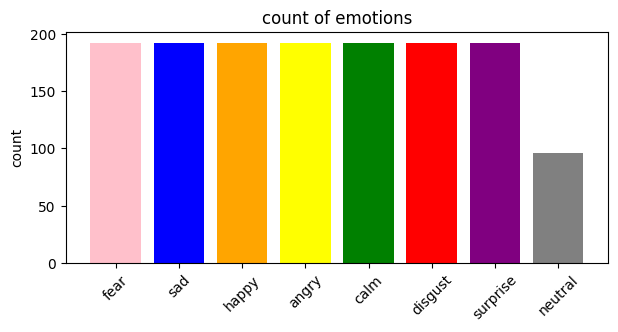

In [ ]:
# Plote um gráfico mostrando as principais emoções do dataframe
# Code here
emotions = {
    "fear": 0,
    "sad": 0,
    "happy": 0,
    "angry": 0,
    "calm": 0,
    "disgust": 0,
    "surprise": 0,
    "neutral": 0,
}
#Nesse loop os values das emoções vão receber +1 quando eles aparecerem assim contando as aparições deles
for index in range(0, len(Ravdess_df)):
    audio_emotion = Ravdess_df.loc[index, 'Emotions']
    emotions[audio_emotion] +=1
plt.figure(figsize=(7, 3))
plt.bar(["fear", "sad", "happy", "angry", "calm", "disgust", "surprise", "neutral"], [emotions["fear"], emotions["sad"], emotions["happy"], emotions["angry"], emotions["calm"], emotions["disgust"], emotions["surprise"], emotions["neutral"]], color=["pink", "blue", "orange", "yellow", "green", "red", "purple", "gray"])
plt.ylabel("count")
plt.title("count of emotions")

plt.xticks(rotation=45)
plt.show

 

#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

In [ ]:
def create_waveplot(data, sr, e):
    # Use a função waveshow do librosa para isso e não se esqueça de colocar um título
    # Code here
    plt.figure(figsize=(9, 3))
    librosa.display.waveshow(data, sr=sr) #plota um gráfico que mostra como a amplitude do aúdio varia ao longo do tempo
    plt.title(f"Waveplot for audio with {e} emotion")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, e):
    # Use a função stft do librosa para transformar os dados e a specshow para plotar o gráfico
    # STFT function converts the data into Short Term Fourier Transform
    # Code here
    db = librosa.amplitude_to_db(librosa.stft(data)) #transformando Short Term Fourier Transform em decibeis
    plt.figure(figsize=(9, 3))
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz', cmap = 'magma') #plota um spectograma que como a frequência varia ao longo do tempo
    plt.title(f"Spectogram for audio with {e} emotion")
    plt.colorbar()
    
    

#### Agora rode as células abaixo para ver os resultados do que você fez :)

#### Emoção de Medo

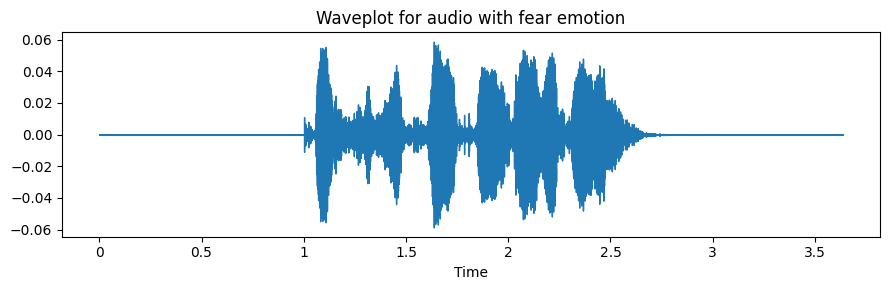

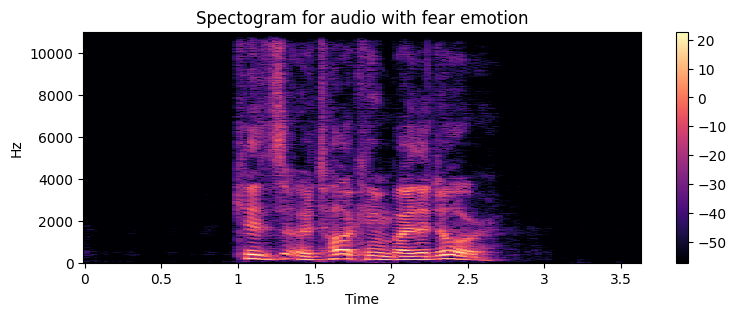

In [9]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### Emoção de felicidade

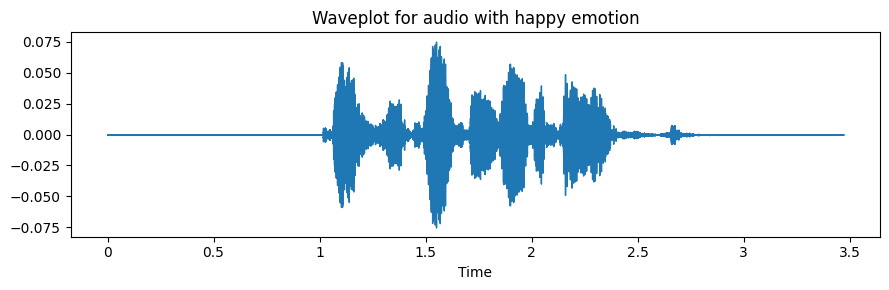

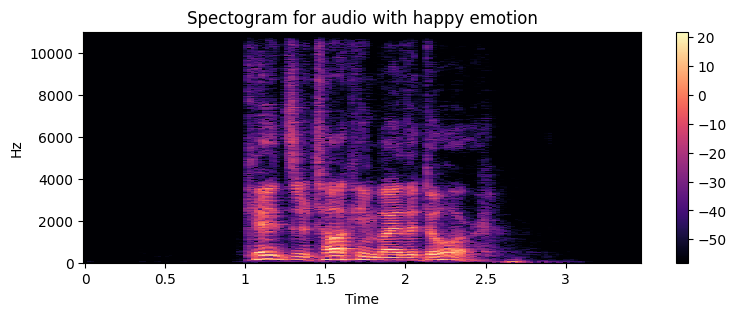

In [10]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Analisar a duração dos áudios

<Axes: xlabel='Path-time', ylabel='Count'>

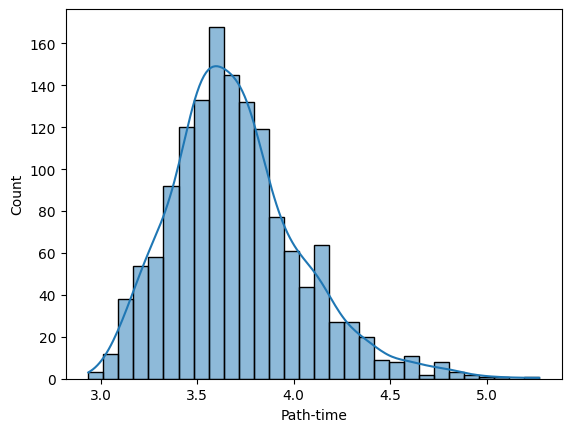

In [ ]:
# Plote um histograma para ver como está a distribuição da duração dos aúdios no dataset
# Code here
duration_list = []
for index in range(0, len(Ravdess_df)):
    audio_path = Ravdess_df.loc[index, "Path"]
    y, sr = librosa.load(audio_path, sr=None) #função que a amostragem do aúdio e a amostragem por segundo
    audio_duration = librosa.get_duration(y=y, sr=sr) #função do librosa que calcula o tempo dividindo o y pelo sr
    duration_list.append(audio_duration)

Df_audios_duration = pd.DataFrame(duration_list, columns=["Path-time"]) #Criando um dataframe a partir da lista duration_list
sns.histplot(Df_audios_duration['Path-time'], kde=True, bins=30) #usando a coluna criada no data-frame para kriar um histograma




### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

In [ ]:
def noise(data):
    noise =np.random.normal(0, data.max(), data.shape) #criando ruído normal
    data_with_noise = data + noise * 0.01 #adicionando o ruído normal ao audio
    return data_with_noise


def stretch(data, rate=0.8):
    # Utilize a função librosa.effects.time_stretch para esticar ou comprimir o áudio pelo fator de taxa especificado.
    # Code here
    audio_slow = librosa.effects.time_stretch(data, rate=0.8)#agora o aúdio está com 80% da velocidade original, ou seja ela vai ficar mais longo
    return audio_slow

def shift(data):
    # Determine um valor de deslocamento aleatório dentro de um intervalo e use np.roll para deslocar o dataset.
    # Code here
    audio_shift = np.roll(data, 5)
    return audio_shift
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Aplique a função librosa.effects.pitch_shift para mudar o pitch do áudio pelo fator especifícado
    # Code here
    
    audio_pitch = librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor) #Com 70% do pitch original  o tom fica mais grave
    return audio_pitch
# Taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

#### 5.1. Simple Audio

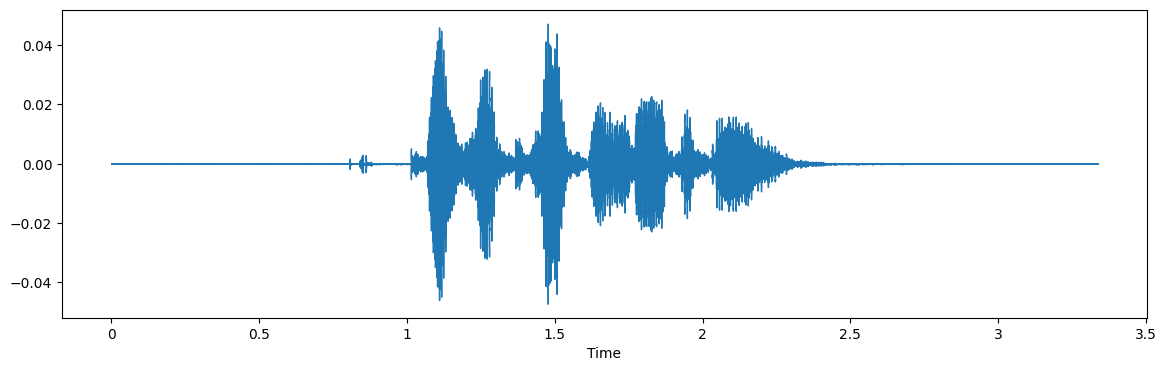

In [13]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

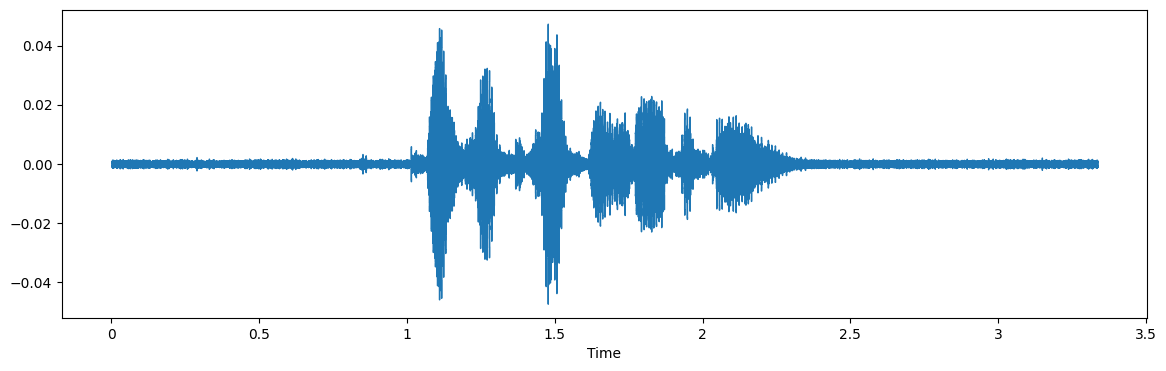

In [14]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

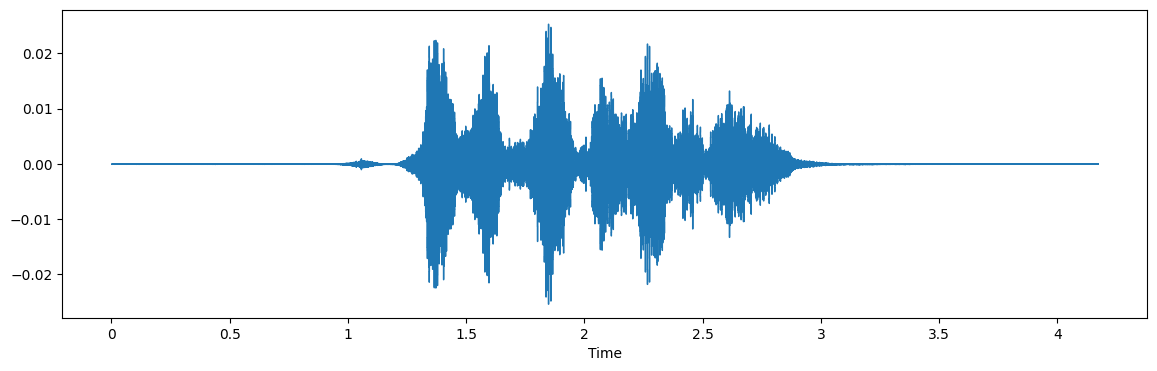

In [15]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

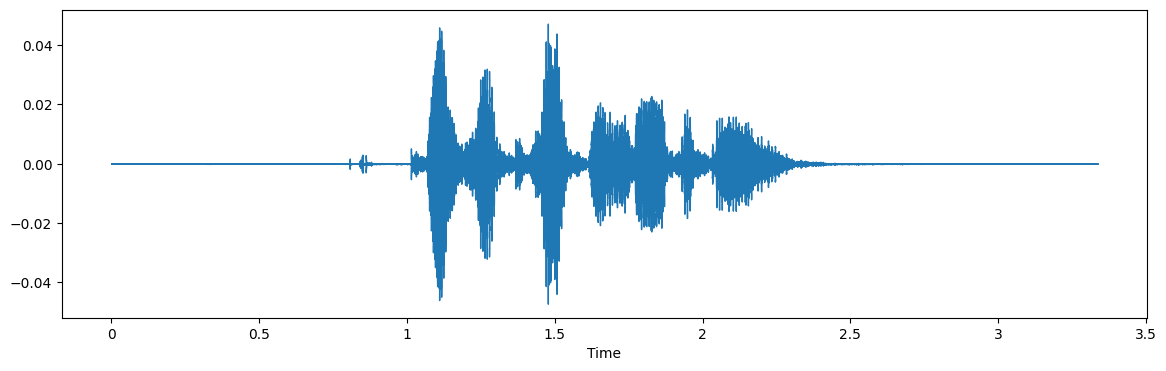

In [16]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

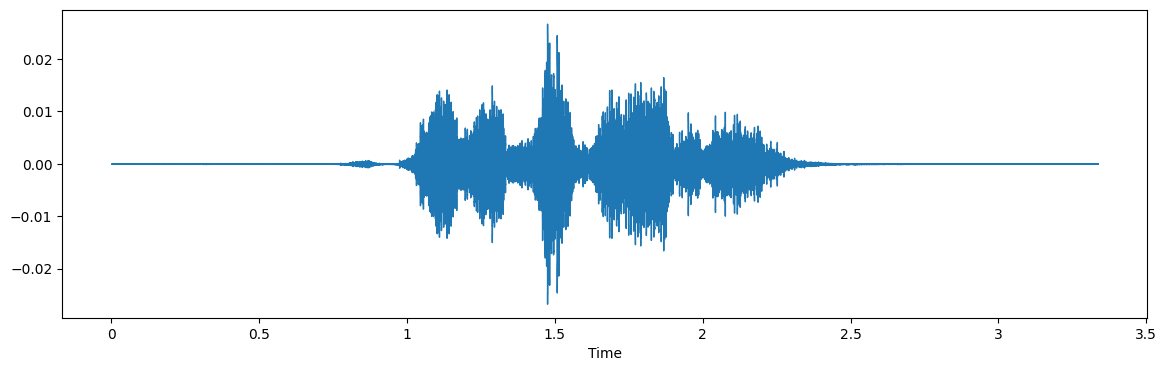

In [17]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [ ]:
import soundfile as sf 

def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    """
    Padroniza e salva os arquivos de áudio.
    
    Args:
    - input_path (str): Caminho do arquivo de entrada.
    - output_dir (str): Diretório para salvar o arquivo processado.
    - target_sr (int): Taxa de amostragem desejada (default: 16000).
    
    Retorna:
    - str: Caminho do arquivo processado.
    """
    os.makedirs(output_dir, exist_ok=True)
    try:
        # Carregue o áudio com librosa.load e converta para mono
        # Code here
        audio_mono, sr = librosa.load(input_path, sr=1600, mono=True) #pegando um arquivo de aúdio e transfomando em um array

        # Determine o output_path, combinando o diretório de saída com o nome do arquivo de entrada
        # Code here
        output_path = os.path.join(output_dir, os.path.basename(input_path)) #novo caminho de arquivo
        # Salvar o áudio processado
        sf.write(output_path, audio_mono, target_sr)
        return output_path
    except Exception as e:
        print(f"Erro ao processar {input_path}: {e}")
        return None

#### 6.2. Aplicar a Padronização a Todos os Áudios

In [19]:
# Definir o caminho correto para salvar os áudios processados na pasta 'data' na raiz do projeto
processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")


# Processar todos os áudios e salvar os novos caminhos
Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir)
)

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: c:\Users\Felipe\Documents\Trilha\projeto_IA\miniprojeto2\data\processed_audio


#### 6.3. Salvar o DataFrame Final

In [20]:
# Garantir que a pasta 'data' exista 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data'
csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

# Salvar o DataFrame no local correto, usa a função to_csv do pandas :)
Ravdess_df.to_csv(csv_path, index=False)
# Code here

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: c:\Users\Felipe\Documents\Trilha\projeto_IA\miniprojeto2\data\ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)